Matplotlib backend: module://matplotlib_inline.backend_inline


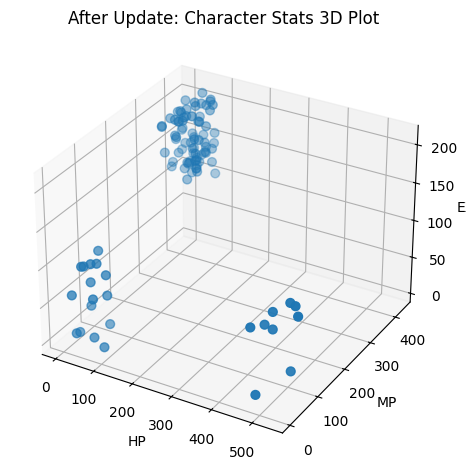

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

%matplotlib inline

import os, sys, sqlite3, numpy as np

# 重要: Aggは使わない（表示したいので）
# バックエンドを可能ならTkAggへ（失敗したら既定のまま）
try:
    import matplotlib
#    matplotlib.use("TkAgg")  # ここでGUIバックエンド指定
except Exception:
    pass

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

DB_NAME = "cit-db-2025-game.db"
PNG = "after_update_scatter.png"

def update_roles(conn):
    cur = conn.cursor()
    # 役割の偏り（必要なければコメントアウト可）
    cur.execute("""UPDATE "character"
                   SET MP = MP + 30, EXP = EXP + 10
                   WHERE character_name='doraemon';""")
    cur.execute("""UPDATE "character"
                   SET HP = HP + 40
                   WHERE character_name='bikkuriko';""")
    conn.commit()

def fetch_stats(conn):
    cur = conn.cursor()
    cur.execute('SELECT HP, MP, EXP FROM "character";')
    rows = cur.fetchall()
    if not rows:
        print("データが空です。", file=sys.stderr)
        sys.exit(1)
    return np.array(rows, dtype=float)

def try_open_file(path):
    try:
        if sys.platform.startswith("win"):
            os.startfile(path)  # type: ignore[attr-defined]
        elif sys.platform == "darwin":
            import subprocess; subprocess.run(["open", path], check=False)
        else:
            import subprocess; subprocess.run(["xdg-open", path], check=False)
    except Exception:
        pass

def main():
    print("Matplotlib backend:", plt.get_backend())

    conn = sqlite3.connect(DB_NAME)
    update_roles(conn)
    stats = fetch_stats(conn)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(stats[:,0], stats[:,1], stats[:,2], s=40, marker="o")
    ax.set_xlabel("HP"); ax.set_ylabel("MP"); ax.set_zlabel("EXP")
    ax.set_title("After Update: Character Stats 3D Plot")
    fig.tight_layout()

    # まず表示を試みる
    try:
        plt.show()  # ここで出なければ exceptへ
        return
    except Exception as e:
        print(f"plt.show() に失敗: {e}\nPNGに保存して開きます。")

    # 表示できない環境向けフォールバック
    fig.savefig(PNG, dpi=150)
    print(f"保存しました → {PNG}")
    try_open_file(PNG)

if __name__ == "__main__":
    main()
